## Visualising High Dimensional Data using Embedding Techniques
Data with dimensions greater than three can be problematic to visualise. Adjusting the plot by adding colour or shapes may allow for more dimensions to be included however as the number of dimensions increase these methods quickly become inadequate. In these situations dimension reduction techniques are often used.  

[t-Distributed Stochastic Neighbor Embedding (t-SNE)](http://lvdmaaten.github.io/tsne/) is one such technique that has become increasing popular since the method was first published in 2008 by Laurens van der Maaten and Geoffrey Hinton. The main parameter involved is called the perplexity, which roughly suggests the number of close neighbours each point has. In general t-SNE is more concerned with local rather than global distances. In other words is something is far away it doesn't matter how far. This is in contrast to methods such as Multi-Dimensional Scaling (MDS).

A more technical description of the algorithim is given by [Alexander Fabisch](http://alexanderfabisch.github.io/t-sne-in-scikit-learn.html):

"t-SNE is a tool for data visualization. It reduces the dimensionality of data to 2 or 3 dimensions so that it can be plotted easily. Local similarities are preserved by this embedding.

t-SNE converts distances between data in the original space to probabilities. First, we compute conditional probabilites

$$p_{j|i} = \frac{\exp{(-||\boldsymbol{x}_i - \boldsymbol{x}_j)||^2 / (2 \sigma_i^2)})}{\sum_{i \neq k} \exp{(-||\boldsymbol{x}_i - \boldsymbol{x}_k)||^2  / (2 \sigma_i^2)})}, \quad p_{i|i} = 0,$$

which will be used to generate joint probabilities

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}.$$

The $\sigma_i$ will be determined automatically. This procedure can be influenced by setting the `perplexity` of the algorithm.

A heavy-tailed distribution will be used to measure the similarities in the embedded space

$$q_{ij} = \frac{(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j)||^2)^{-1}}{\sum_{i \neq k} (1 + ||\boldsymbol{y}_i - \boldsymbol{y}_k)||^2)^{-1}},$$

and then we minimize the Kullback-Leibler divergence

$$KL(P|Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

between both distributions with gradient descent (and some tricks). Note that the cost function is not convex and multiple runs might yield different results."


The example below involves trying to visualise the MNIST hand drawn digits dataset using a number of dimensionality reduction methods. The code is heavily based on that found on the scikitlearn [examples page](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py)


First we import the required libraries, dataset, and a function to plot the results (since we'll be doing it a lot). Finally we plot a sample of the images.

Populating the interactive namespace from numpy and matplotlib


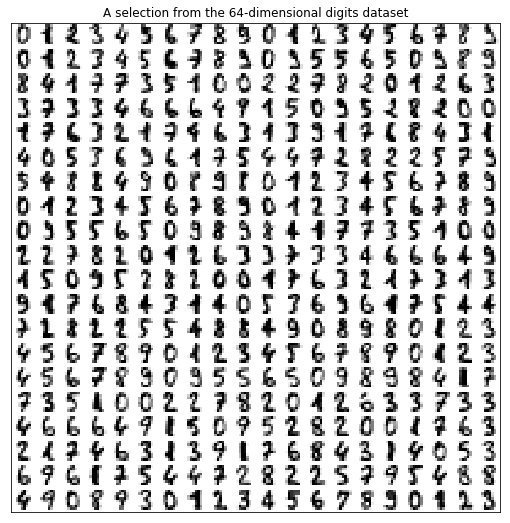

In [1]:
%pylab inline
## importing the required packages
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
             discriminant_analysis, random_projection)

rcParams["figure.figsize"] = (17, 9)
## Loading and curating the data
digits = datasets.load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30
## Function to Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                ## don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


## Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

You can also check what the data looks like. For example the first digit:


In [2]:
X[0]

array([  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
        15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
         8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
         5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
         1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
         0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.])

Now lets try and reduce the dimensions from 64 to 2 for plotting using PCA

Computing PCA projection


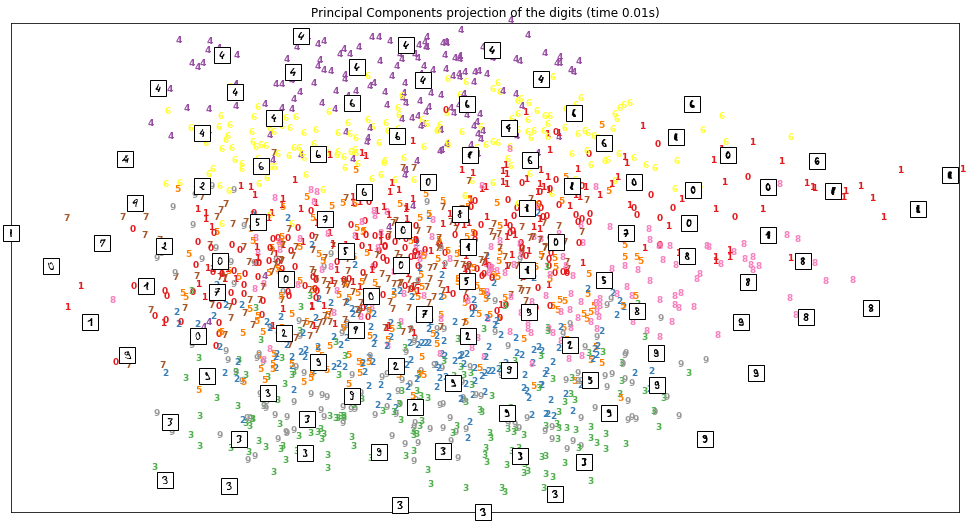

In [3]:
## Computing PCA
print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))




MDS

Computing MDS


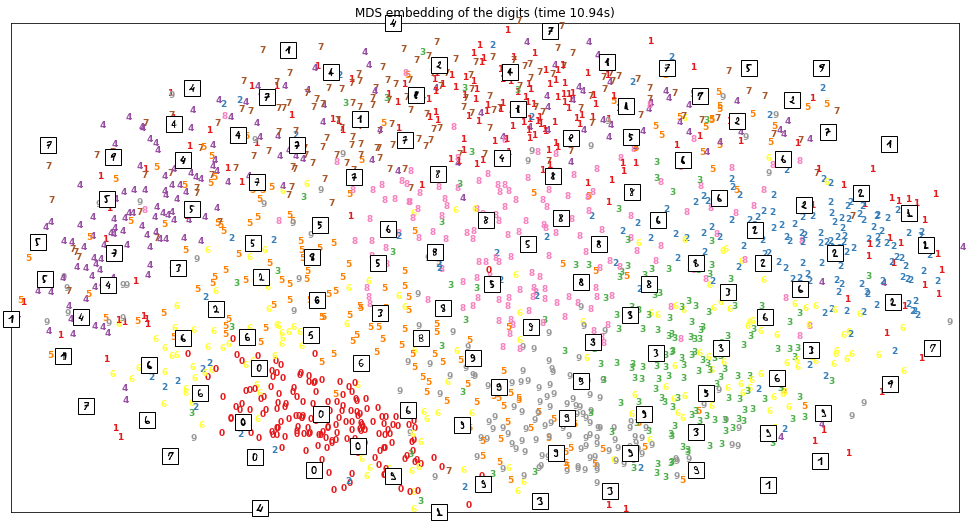

In [4]:
print("Computing MDS")
mds = manifold.MDS(n_components=2, max_iter=100, n_init=1)
#tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_mds = mds.fit_transform(X)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

And finally t-SNE . Note that we use pca to get the initial embedding. We use the default parameter values for perplexity, learning rate, and iterations. We also set the random state so that we get the same results when we re-run the code.

Computing t-SNE embedding


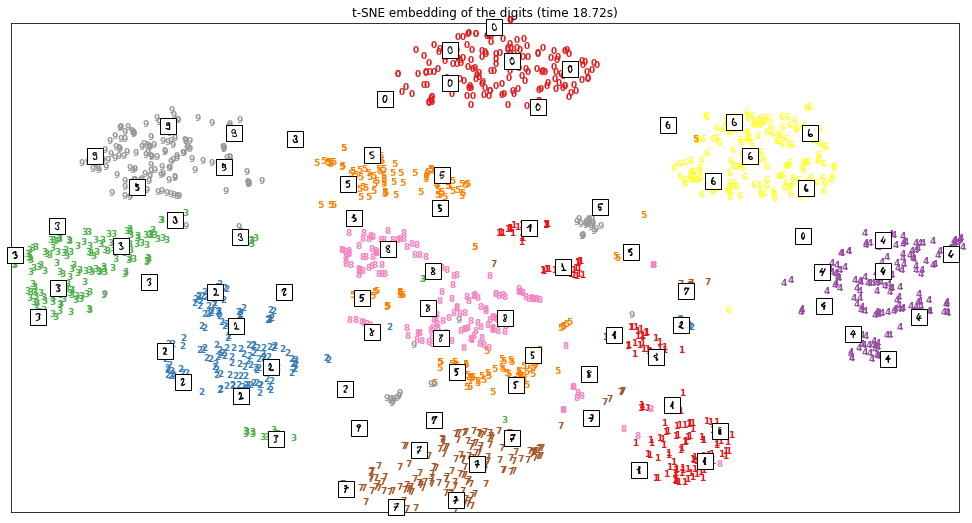

In [5]:
## Computing t-SNE
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca',perplexity=30,learning_rate=1000, n_iter=1000, random_state=0)
t0 = time()
t1 = time() - t0
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

You could try and change the perplexity (recommended to be between 5 and 50), learning rate (between 100 and 1000), or interation (>100). A great demonstration of the effect of altering these parameters can be found on [Distill](http://distill.pub/2016/misread-tsne/).

In [ ]:
## Computing t-SNE
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca',perplexity=50,learning_rate=100, n_iter=200, random_state=0)
t0 = time()
t1 = time() - t0
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne,
               "t-SNE embedding of the digits redone (time %.2fs)" %
               (time() - t0))

You could also plot the results as points.

In [ ]:
scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
my_colorbar = colorbar(fraction=0.05, pad = 0.0125)
xticks([]); yticks([])

Or just plot the actual images:

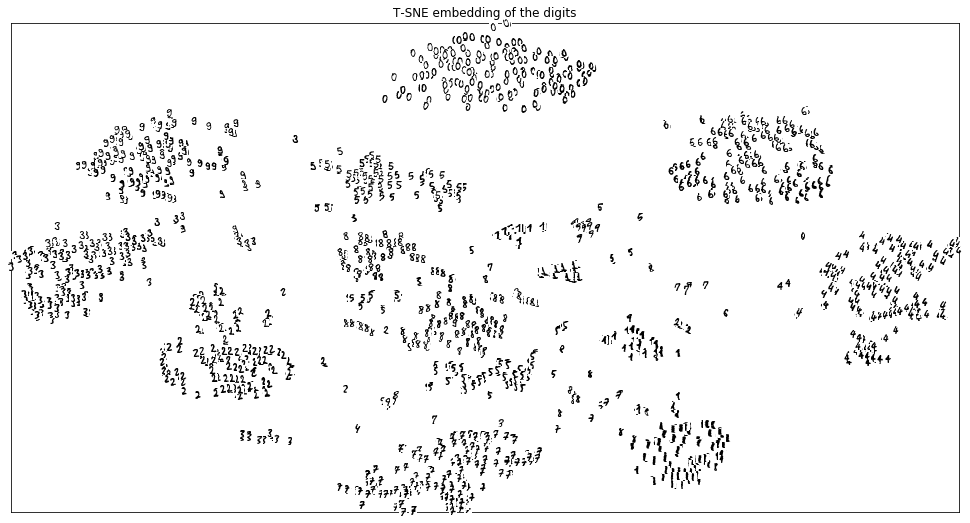

In [6]:
## Modified Function to Scale and visualize the embedding vectors
def plot_embedding_images(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)     
    plt.figure()
    ax = plt.subplot(111)
    if hasattr(offsetbox, 'AnnotationBbox'):
        ## only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i],frameon=False)
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

##plot 
plot_embedding_images(X_tsne,
               "T-SNE embedding of the digits")
plt.show()

For a nice exmple of using t-SNE with twitter data using python and javascript can be found on Andre Karparthy's [blog](http://karpathy.github.io/2014/07/02/visualizing-top-tweeps-with-t-sne-in-Javascript/) with a live demo found [here](http://cs.stanford.edu/people/karpathy/tsnejs/).